In [20]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [21]:
ticker_list = ['AAPL', 'GLD','NFLX','GOOG']
start_date = '2020-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

In [22]:
df_new=yf.download(ticker_list, start=start_date, end=end_date)['Close']
# df_new=yf.download(temp, start=start_date, end=end_date)
df=df_new

/var/folders/y7/hf6140q96774323j7d756khw0000gn/T/ipykernel_77754/1610131339.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  4 of 4 completed


In [23]:
df.head()

Ticker,AAPL,GLD,GOOG,NFLX
Date,,,,
2020-01-02,72.538513,143.949997,67.964508,329.809998
2020-01-03,71.833313,145.860001,67.630989,325.899994
2020-01-06,72.405678,147.389999,69.298584,335.829987
2020-01-07,72.065155,147.970001,69.255333,330.750000
2020-01-08,73.224411,146.860001,69.801102,339.260010


In [24]:
initial_weights = [0.25,0.25,0.25,0.25]
initial_capital = 100000
# Step 1: Compute prices relative to the first day
price_relative = df/df.iloc[0]  # Each asset starts at 1.0

# Step 2: Scale each asset's return path by initial weights and capital
position_values = price_relative * initial_capital *initial_weights

# Step 3: Total portfolio value = sum of asset positions
portfolio_value = position_values.sum(axis=1)

# Step 4: Calculate how weights drift over time
weights_over_time = position_values.div(portfolio_value, axis=0)

# Step 5: Combine into one DataFrame
pf_df = pd.DataFrame({
    'Portfolio Value': portfolio_value,
    'AAPL Weight': weights_over_time['AAPL'],
    'NFLX Weight': weights_over_time['NFLX'],
    'GOOG Weight': weights_over_time['GOOG'],
    'GLD Weight': weights_over_time['GLD']
})

# Preview
pf_df.head()

,Portfolio Value,AAPL Weight,NFLX Weight,GOOG Weight,GLD Weight
Date,,,,,
2020-01-02,100000.000000,0.250000,0.250000,0.250000,0.250000
2020-01-03,99669.605320,0.248390,0.247855,0.249598,0.254157
2020-01-06,101498.696842,0.245858,0.250804,0.251143,0.252195
2020-01-07,101081.088684,0.245712,0.248031,0.252024,0.254233
2020-01-08,102133.668680,0.247092,0.251791,0.251392,0.249726


In [25]:
pf_df.tail()

,Portfolio Value,AAPL Weight,NFLX Weight,GOOG Weight,GLD Weight
Date,,,,,
2025-08-11,298399.427247,0.262388,0.309482,0.248551,0.179579
2025-08-12,300661.036435,0.263245,0.308912,0.249776,0.178067
2025-08-13,300097.218509,0.267966,0.304228,0.248861,0.178945
2025-08-14,301837.801212,0.265793,0.309033,0.248388,0.176785
2025-08-15,302495.840296,0.263859,0.310463,0.249173,0.176504


In [26]:
# Reset index for plotting
weekly_df = pf_df.resample('W').last().dropna()
df_plot = weekly_df.reset_index().copy()

df_plot.rename(columns={'index': 'Date'}, inplace=True)

# Create subplots: 2 rows, shared x-axis
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.1,
    subplot_titles=("Portfolio Value Over Time", "Portfolio Allocation (SPY & TLT)")
)

# Line plot of portfolio value
fig.add_trace(
    go.Scatter(
        x=df_plot['Date'],
        y=df_plot['Portfolio Value'],
        mode='lines',
        name='Portfolio Value',
        line=dict(width=2)
    ),
    row=1, col=1
)
#['AAPL', 'GLD','NFLX','GOOG']
# Bar plot: SPY weight
fig.add_trace(
    go.Bar(
        x=df_plot['Date'],
        y=df_plot['AAPL Weight'],
        name='AAPL',
        marker=dict(color='steelblue')
    ),
    row=2, col=1
)

# Bar plot: TLT weight
fig.add_trace(
    go.Bar(
        x=df_plot['Date'],
        y=df_plot['GLD Weight'],
        name='GLD',
        marker=dict(color='darkorange')
    ),
    row=2, col=1
)
# Bar plot: GE weight
fig.add_trace(
    go.Bar(
        x=df_plot['Date'],
        y=df_plot['NFLX Weight'],
        name='NFLX',
        marker=dict(color='yellowgreen')
    ),
    row=2, col=1
)
# Bar plot: GOOG weight
fig.add_trace(
    go.Bar(
        x=df_plot['Date'],
        y=df_plot['GOOG Weight'],
        name='GOOG',
        marker=dict(color='brown')
    ),
    row=2, col=1
)

# Update layout
fig.update_layout(
    height=550,
    title_text='Portfolio Performance and Allocation Over Time',
    barmode='stack',
    template='seaborn',
    showlegend=True
)

# Format axes
fig.update_yaxes(title_text='Portfolio Value ($)', row=1, col=1)
fig.update_yaxes(title_text='Allocation Weight', range=[0, 1],tickvals=[0.6], row=2, col=1)
fig.update_xaxes(title_text='Date', row=2, col=1)

# Show plot
fig.show()


In [27]:
# 'YE' = Year-end, 'QE' = Quarterly, 'ME' = Monthly
rebalance_frequency = 'QE'
rebalance_dates = df.resample(rebalance_frequency).last().index
print("rebalancing will occur at", rebalance_dates)

rebalancing will occur at DatetimeIndex(['2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
               '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31',
               '2022-03-31', '2022-06-30', '2022-09-30', '2022-12-31',
               '2023-03-31', '2023-06-30', '2023-09-30', '2023-12-31',
               '2024-03-31', '2024-06-30', '2024-09-30', '2024-12-31',
               '2025-03-31', '2025-06-30', '2025-09-30'],
              dtype='datetime64[ns]', name='Date', freq='QE-DEC')


In [28]:
portfolio_value = pd.Series(index=df.index, dtype=float)
allocation_history = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)

current_weights = initial_weights
weights = initial_weights

for i in range(len(rebalance_dates)):
    start_1date = df.index[0] if i == 0 else rebalance_dates[i - 1] + pd.Timedelta(days=1)
    end_date = rebalance_dates[i]
    # print(f"rebalanning period:{i+1} {start_date} to {end_date}")
    # portfolio_value[rebalance_dates[i]] = portfolio_value[rebalance_dates[i - 1]] * (1 + df.loc[rebalance_dates[i]].dot(weights))
    # allocation_history.loc[rebalance_dates[i]] = weights

In [29]:
# Initialize storage
portfolio_value = pd.Series(index=df.index, dtype=float)  
allocation_history = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)       # stores allocation across each row

current_value = initial_capital
weights = initial_weights

# Loop through each rebalance period
for i in range(len(rebalance_dates)):
    # Start and end date of the period
    start_date = df.index[0] if i == 0 else rebalance_dates[i - 1] + pd.Timedelta(days=1)    # we want to start the day after the previous rebalance date
    end_date = rebalance_dates[i]
    print(f"Rebalancing period {i+1}: {start_date.date()} to {end_date.date()}")             # visualising non overlapping periods
 

    # Slice price data for the period
    period_prices = df.loc[start_date:end_date]

    # Price relative to the first day of this period
    relative_returns = period_prices / period_prices.iloc[0]

    # Compute position values for each asset
    position_vals = relative_returns * current_value * weights                 

    # Portfolio value = sum of positions
    period_portfolio = position_vals.sum(axis=1)
    portfolio_value.loc[period_portfolio.index] = period_portfolio

    # Calculate allocation (weight) = position / portfolio total
    allocation = position_vals.div(period_portfolio, axis=0)
    allocation_history.loc[allocation.index] = allocation

    # Update for next period
    current_value = period_portfolio.iloc[-1]
    weights = np.array(initial_weights)  # rebalance to target

# Build rebalanced portfolio DataFrame
rebalanced_pf_df = pd.DataFrame({
    'Portfolio Value': portfolio_value,
    'Portfolio Return': portfolio_value.pct_change()
})

# Add asset weights
for asset in df.columns:
    rebalanced_pf_df[f"{asset} Weight"] = allocation_history[asset]


Rebalancing period 1: 2020-01-02 to 2020-03-31
Rebalancing period 2: 2020-04-01 to 2020-06-30
Rebalancing period 3: 2020-07-01 to 2020-09-30
Rebalancing period 4: 2020-10-01 to 2020-12-31
Rebalancing period 5: 2021-01-01 to 2021-03-31
Rebalancing period 6: 2021-04-01 to 2021-06-30
Rebalancing period 7: 2021-07-01 to 2021-09-30
Rebalancing period 8: 2021-10-01 to 2021-12-31
Rebalancing period 9: 2022-01-01 to 2022-03-31
Rebalancing period 10: 2022-04-01 to 2022-06-30
Rebalancing period 11: 2022-07-01 to 2022-09-30
Rebalancing period 12: 2022-10-01 to 2022-12-31
Rebalancing period 13: 2023-01-01 to 2023-03-31
Rebalancing period 14: 2023-04-01 to 2023-06-30
Rebalancing period 15: 2023-07-01 to 2023-09-30
Rebalancing period 16: 2023-10-01 to 2023-12-31
Rebalancing period 17: 2024-01-01 to 2024-03-31
Rebalancing period 18: 2024-04-01 to 2024-06-30
Rebalancing period 19: 2024-07-01 to 2024-09-30
Rebalancing period 20: 2024-10-01 to 2024-12-31
Rebalancing period 21: 2025-01-01 to 2025-03-31
R

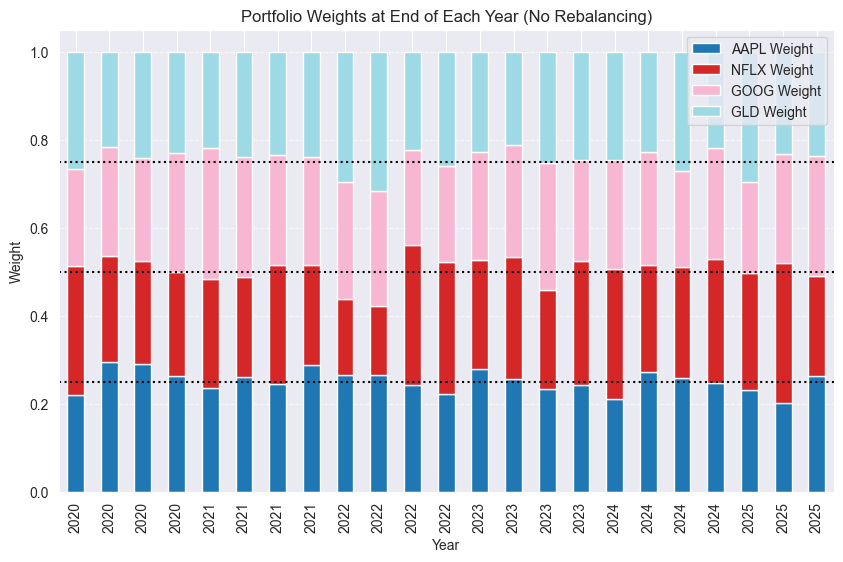

<Figure size 600x400 with 0 Axes>

In [30]:
# Extract weights at the end of each year
year_end_weights = rebalanced_pf_df.resample('QE').last()[['AAPL Weight', 'NFLX Weight', 'GOOG Weight', 'GLD Weight']]
year_end_weights.index = year_end_weights.index.year  # Make x-axis labels cleaner

# Plot a stacked bar chart
ax = year_end_weights.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    colormap='tab20'
)

# Add a horizontal line at 60% to show target SPY weight
plt.axhline(y=0.25, color='black', linestyle='dotted', linewidth=1.5)
plt.axhline(y=0.5, color='black', linestyle='dotted', linewidth=1.5)
plt.axhline(y=0.75, color='black', linestyle='dotted', linewidth=1.5)
# Labels and styling
plt.title('Portfolio Weights at End of Each Year (No Rebalancing)')
plt.ylabel('Weight')
plt.xlabel('Year')
plt.ylim(0, 1.05)
plt.legend(loc='upper right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.figure(figsize=(6,4))
plt.tight_layout()
plt.show()


In [31]:
# Reset index for plotting
weekly_df = rebalanced_pf_df.resample('W').last().dropna()
df_plot = weekly_df.reset_index().copy()

df_plot.rename(columns={'index': 'Date'}, inplace=True)

# Create subplots: 2 rows, shared x-axis
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.1,
    subplot_titles=("Portfolio Value Over Time", "Portfolio Allocation (SPY & TLT)")
)

# Line plot of portfolio value
fig.add_trace(
    go.Scatter(
        x=df_plot['Date'],
        y=df_plot['Portfolio Value'],
        mode='lines',
        name='Portfolio Value',
        line=dict(width=2)
    ),
    row=1, col=1
)

# Bar plot: SPY weight
fig.add_trace(
    go.Bar(
        x=df_plot['Date'],
        y=df_plot['AAPL Weight'],
        name='AAPL',
        marker=dict(color='steelblue')
    ),
    row=2, col=1
)

# Bar plot: TLT weight
fig.add_trace(
    go.Bar(
        x=df_plot['Date'],
        y=df_plot['NFLX Weight'],
        name='NFLX',
        marker=dict(color='darkorange')
    ),
    row=2, col=1
)

# Bar plot: GE weight
fig.add_trace(
    go.Bar(
        x=df_plot['Date'],
        y=df_plot['GOOG Weight'],
        name='GOOG',
        marker=dict(color='yellowgreen')
    ),
    row=2, col=1
)

# Bar plot: GLD weight
fig.add_trace(
    go.Bar(
        x=df_plot['Date'],
        y=df_plot['GLD Weight'],
        name='GLD',
        marker=dict(color='brown')
    ),
    row=2, col=1
)

# Update layout
fig.update_layout(
    height=550,
    title_text='Portfolio Performance and Allocation Over Time',
    barmode='stack',
    template='seaborn',
    showlegend=True
)

# Format axes
fig.update_yaxes(title_text='Portfolio Value ($)', row=1, col=1)
fig.update_yaxes(title_text='Allocation Weight', range=[0, 1],tickvals=[0.6], row=2, col=1)
fig.update_xaxes(title_text='Date', row=2, col=1)

# Show plot
fig.show()


In [32]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create the figure
fig = go.Figure()

# Add traces for both portfolio values
fig.add_trace(go.Scatter(
    x=rebalanced_pf_df.index,
    y=rebalanced_pf_df['Portfolio Value'],
    mode='lines',
    name='With Rebalancing',
    line=dict(width=2)
))

fig.add_trace(go.Scatter(
    x=pf_df.index,
    y=pf_df['Portfolio Value'],
    mode='lines',
    name='Without Rebalancing',
    line=dict(width=2)
))

# Update layout
fig.update_layout(
    title='Portfolio Value Over Time',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
    width=1000,
    height=500,
    showlegend=True,
    template='seaborn'
)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', griddash='dash')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray', griddash='dash')

# Show the plot
fig.show()

In [33]:
# Set trading days in a year
trading_days = 252

# Define a function to calculate metrics
def compute_metrics(pf_series):
    # Daily returns
    returns = pf_series.pct_change().dropna()

    # Annualized return
    ann_return = (pf_series.iloc[-1] / pf_series.iloc[0]) ** (trading_days / len(returns)) - 1

    # Annualized volatility
    ann_volatility = returns.std() * np.sqrt(trading_days)

    # Max drawdown
    cum_returns = pf_series / pf_series.iloc[0]
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    return [ann_return, ann_volatility, max_drawdown]

# Compute metrics for both portfolios
pf_metrics = compute_metrics(pf_df['Portfolio Value'])
rebal_metrics = compute_metrics(rebalanced_pf_df['Portfolio Value'])

# Create comparison table
metrics_df = pd.DataFrame(
    [pf_metrics, rebal_metrics],
    columns=['Annualized Return %', 'Annualized Volatility %', 'Max Drawdown %'],
    index=['Without Rebalancing', 'With Rebalancing']
)*100


In [34]:
metrics_df

,Annualized Return %,Annualized Volatility %,Max Drawdown %
Without Rebalancing,21.841185,23.326805,-34.851507
With Rebalancing,23.506178,22.739569,-34.855726
